# Assignment 1: MA338

#### Instructions

1. This Notebook will provide you the Tasks you have to complete, include a couple of questions, and define the necessary functions that you could use.
2. You have to submit your modified version of this Notebook to FASER. Write in the title **Assignment-1-RegNumb-#YOUR REGISTRATION NUMBER#.ipynb**
3. You can include as many extra cells as you need to make some comments (remember selecting Markdown cell instead of Code cell)
4. Adding extra (related) stuff could help with grade: For example some nice plots/drawing (you can insert images on Jupyter notebooks, but you need to attach the image in the submission).
5. This notebook will have several sections associated to different tasks you have to complete. In each one of them I will provide what functions you need to complete (for example policy evaluation, value iteration...)
6. If you prefer not to follow the suggested structure but decide to program it in a different way, you can do it, as long as you explain all the processes and complete all the tasks.
    
    

#### General libraries

In [1133]:
import gym
import numpy as np # to work with mathematical operations
import time # to reduce the speed of simulations
import random # to randomly generate data
import matplotlib.pyplot as plt # to plot
from IPython.display import clear_output # Used to clearthe ouput of a Jupyter cell.

Run these commands to download and install the latest version of GridWorld (if you already installed it for the Lab 2, it should be ok)

```bash
git clone https://github.com/andremht/gym-gridworld.git
cd gym-gridworld
pip3 install -e .
```

In [1134]:
import gym_gridworld

##### Utilities

The following functions can be useful to run the agents that you will create, as well as display the results in the notebook.

In [1135]:
## The following function will be use to evaluate the different policies.
# The environment env will define what type of grid we will use
# Agent will be defined according different policies
# tsleep is used to create slower iterations so we can see how the agent moves in the grid


def run_agent(env, agent, tsleep = 0.05):
    state = env.reset()
    time_step = 0
    total_reward = 0
    reward = 0;
    done = False
    while not done:
        action = agent.act(state, done);
        state, reward, done, info = env.step(action)  # step is defined into the environment, and it provides the new state, the reward obtained, and whether we finished or not
        total_reward += reward
        time_step += 1
        clear_output(wait=True)  # to have a different displayed result on the screen
        env.render()    # this code displays the agent state and action
        print("Time step:", time_step)
        print("State:", state)
        print("Action:", action)
        print("Total reward:", total_reward)
        time.sleep(tsleep)  # to delay the transitions

In [1136]:
#This function will an array and turn it into the grid format, and then plot the value function with a colourmap 

def plot_values(VF, size= (5,5), name = None):
# reshape value function according to the size of the grid (rows and columns)
    VF_grid = np.reshape(VF, size)

# plot the state-value function
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    im = ax.imshow(VF_grid, cmap='cool')
    fig.colorbar(im, ax=ax)   #  colourbar to indicate which is higher and lower
    for (j,i),label in np.ndenumerate(VF_grid):
        ax.text(i, j, np.round(label, 5), ha='center', va='center', fontsize=14)
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.title(name+'-Value Function')
    if name == 'Policy':
            plt.title(name)
    plt.show()

We can try some examples for the function plot_values, so you can have an idea what it does

In [1137]:
Q = [1,3,4,6,20,4,1,5]
Q = np.array(Q)
V= 2*np.round(np.random.random_sample((16,)),2)+3

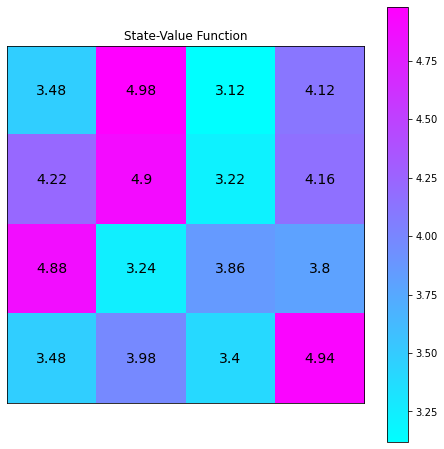

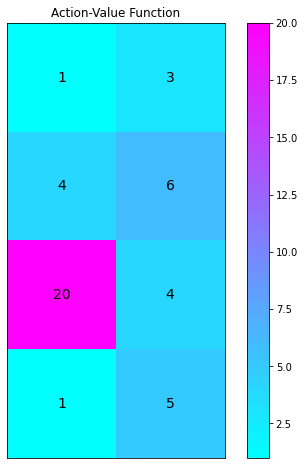

In [1138]:
plot_values(V,size=(4,4), name='State')
plot_values(Q, size=(4,2), name='Action')

***
### Key variables in RL and OpenAI Gym

For this assignment we will explore two variants of the Gridworld. The first one `'GridWorld-3x3-Wall-v0'` is a grid of 3x3 and contains a wall in some cells that do not allow to move on those directions. The second one is known as `FrozenLake-v1` which contains a few cells with holes that once the agent step on it, it drowns and the episode finishes. We will give more details once we start working with them. In the meantime a few reminders on OpenAI Gym variables.

* __Agent__: The learner and decision maker. This is a class you should create.
* __Environment__:  What the agent interacts with. This is the variable `env` in `env = gym.make(version of gridworld)`. In GridWorld, a particularly important variable is `env.P`, which contains the Markov process model of the system. This variable encodes the state transition probabilities, rewards, and other information. 
* __State__: A state $s \in \mathcal{S}$ is a succinct representation of the environments current state. The current sate can be obtained by `env.s`
* __Action__: The agent can take actions $a \in \mathcal{A}$ in order to change the state of the environment. It is an element of `env.action_space`.
* __Policy__: Rules for how the agent choses the next action given the current state, $a = \pi(s)$.
* __Reward__: An immediate reward $R(s,a)$ that the agent gets for taking action $a$ in state $s$. A reward depends on a state and action, so it can only be obtain through the `step` function, which in turn updates the environments state.



##  Dynamic Programming

#### GridWorld 3x3 with a Wall.

In [1139]:
env_GW = gym.make('GridWorld-3x3-Wall-v0')
state = env_GW.reset()  #will set the agent into a random initial state
print('Initial state:', state) #reminder: python starts counting from 0
print("State space:", env_GW.observation_space) # observations and states will be the same for us in this module
print("Action space:", env_GW.action_space) # all the available actions and their type: discrete or continuous
env_GW.render()

Initial state: 6
State space: Discrete(9)
Action space: Discrete(4)

FFF
FWF
SWG


__State space__: We see that the state space contains 9 discrete states. In this case each state corresponds to a position of the agent (3x3=9 possibilities).  
But some of those states are not accesible, since there is a wall on them (states *4* and *7*.
State *6* is the starting point **S**, and state *8* is the goal **G**. 

__Action space__: The 4 discrete actions corresponds to: 0 - Left, 1 - Down, 2 - Right, 3 - Up. 

In [1140]:
new_state, reward, done, info = env_GW.step(2) # Take action 3 (Up)
env_GW.render() #displays the results
print("New state:", new_state)
print("Reward:", reward)
print("Done:", done)

  (Right)
FFF
FWF
SWG
New state: 6
Reward: -1.0
Done: False


We define now a uniform random agent (that does not learn, only acts)

In [1141]:
class RandomAgent(object):
    def __init__(self, nA, nS):
        self.nA = nA
        self.nS = nS
        self.probs = np.ones((self.nS,self.nA))/self.nA #uniformly random probability (0.25 to each option)
        

    def act(self, state, done):
        # IMPORTANT: the following code allows to select randomly an action, given a probability distribution p
        action = np.random.choice(np.arange(self.nA), p=self.probs[state], replace = False) 
        return action # a random policy

In [1142]:
agent_uniform = RandomAgent(env_GW.nA, env_GW.nS) #an instantiation of an agent of the class RandomAgent

In [1143]:
run_agent(env_GW, agent_uniform, tsleep = 0.05)

  (Down)
FFF
FWF
SWG
Time step: 27
State: 8
Action: 1
Total reward: -27.0


*Remark*: notice that in this grid we can easily spot the optimal policy, but a random agent struggles to find it. 

### Task 1.1: Bellman Equation

The following functions will help you to write the Bellman Equation for $v_{\pi}$ in a iterative way. 

**Your task here is to write down the respective pseudo code for each function, or alternatively, the equations or backup diagrams associated. You can either write it directly here using LaTeX, or include an image in your submission.**

In [1144]:
'''
Function Q_from_V(environment, state, V)
    {
        action_values:= 1 x action_number vector of zeros
        
        for each action A do
        
            {
                action_values[A] := compute the summation of p*(reward+ GAMMA * V[state'])
            }
        
        return action_values
    }
    
    
    
Function weighted_action_value(environment, agent, action_values, state)
    {
        for each action A do
            {
                result:= compute the summation of P(state|A) * value of the action
            }
        
        return result
    }
    

Function Bellman_equation_RHS(environment, agent, old_V)
    {
        V:= 1 x number_of_states zero vector
        
        for each state s 
            {
                if we are at terminal node then V[s] := 0
                
                otherwise
            
                    action_values := Q_from_V(environment, s, old_V)
                    V[s] := weighted_action_value(environment, agent, action_values, s)
    
            }
       
        
        return V
        
        
    }

'''
print("")

In [1145]:
# Set up the discount factor
GAMMA = 0.7 # defined as a global variable, so you can easily change it if needed.

#For each action, computes the effect of the action, and update discounted reward for that action
def Q_from_V(env, s, value_function):
    action_values = np.zeros(env.nA)
    for a in range(env.nA):
        for p, next_s, reward, _ in env.P[s][a]:
            action_values[a] += p * (reward + GAMMA * value_function[next_s])   # a += 1 is the same than a = a+1
    return action_values

# Compute the expected state-value according to the action policy, 
# where the weights are the associated probabilities agent.probs
def weighted_action_value(env, agent, action_values, s):
    weighted_value = 0
    action_set = range(agent.nA)
    for action in action_set:
        weighted_value += agent.probs[s , action] * action_values[action] 
    return weighted_value

def Bellman_equation_RHS(env, agent, old_value_function):    #the righthand side of the Bellman Equation for V
    value_function = np.zeros(env.nS)
    for s in range(env.nS):
        if env.is_terminal(s):
            value_function[s] = 0.0
        else:
            action_values = Q_from_V(env, s, old_value_function)
            value_function[s] = weighted_action_value(env, agent, action_values, s)
    return value_function



### Task 1.2

The following function will compute the Iterative Policy Evaluation algorithm. **Yor task is to complete the following function where it says `# YOUR CODE HERE`**

In [1146]:
def policy_evaluation(env, agent, old_value, attempts=20, tol=1e-6):  
    # attempts is written in case we don't converge fast enough. Probably not an issue for this problem, 
    # but for others it may be relevant
    # old_value - we store the previous value here
    for i in range(attempts):
        # YOUR CODE HERE (you need to define how new_value is computed. You can the functions from Task 1.1)
        new_value = Bellman_equation_RHS(env, agent, old_value)
        if np.max(np.abs(new_value-old_value)) < tol:
            break
        old_value = new_value
    return new_value

In [1147]:
policy_evaluation(env_GW, agent_uniform, np.zeros(env_GW.nS))

array([-3.30695961, -3.24847952, -3.04749791, -3.32380528, -3.105978  ,
       -2.3586414 , -3.3282895 , -2.43396716,  0.        ])

### Task 1.3

The following function will compute a *Policy Improvement* over the current policy $\pi$.

**Your task is to write that function.** HINT: you can use the function `Q_from_V` from **Task 1.1** to create the new policy.

In [1148]:
def policy_improvement(env, agent, value_function):
    new_probs = np.ones([env.nS, env.nA]) / env.nA
    stable_policy = False
    for s in range(env.nS):
        # Choose the best action in a current state under current policy
        current_action = np.argmax(new_probs[s])
        # Look one step ahead and evaluate if current action is optimal
        # We will try every possible action in a current state
        action_value = Q_from_V(env, s, value_function)
        # Select a better action
        best_action = np.argmax(action_value)
        # If action didn't change
        if current_action != best_action:
            stable_policy = True
            # Greedy policy update
            new_probs[s] = np.eye(env.nA)[best_action]
    agent.probs = new_probs
    return new_probs, stable_policy
# this function does not return anything, it just modifies the probabilities of the agent according to the 
# improved policy. You can also create an alternative version where the new policy is returned.

### Task 1.4

The following function should combined both functions from  **Task 1.2** and **Task 1.3** to create a Policy Iteration Algorithm.

**Your task is to write that function**. It should return both the Optimal Policy and the Optimal State Value Function. 

You can do this in more than one cell. For example use the following function to compute the optimal state value $v$, use that to obtain the optimal action value  $q$, and with that define the optimal policy. But you also can do it in one step.

In [1149]:
def policy_iteration(env, agent, value_function, MaxIter=1000, tol=1e-6): 
    #run it until no changes (tol) or until we run out of time (MaxIter)
    optimal_value_function = value_function   #initialisation
    optimal_policy = np.ones([env.nS, env.nA]) / env.nA  #  initialisation
    policy_stable = False
    i = 0
    while (not policy_stable) and (i<=MaxIter):
        i += 1
        # Run the policy evaluation
        optimal_value_function = policy_evaluation(env, agent, optimal_value_function)
        # Run the policy improvement algorithm
        optimal_policy, stable_policy = policy_improvement(env, agent, optimal_value_function)
    return optimal_policy, optimal_value_function  

In [1150]:
policy_iteration(env_GW, agent_uniform, np.zeros(env_GW.nS))
run_agent(env_GW,agent_uniform)

  (Down)
FFF
FWF
SWG
Time step: 6
State: 8
Action: 1
Total reward: -6.0


### Task 1.5
Similar to the previous point the following function is the Value Iteration Algorithm

**Your task is to create that function**. The procedure should be similar to **Task 1.4** but you merged a couple of steps (sweeps) into one.  You should provide the Optimal State Function and the respective Optimal Policy.



In [1151]:
def value_iteration(env, agent, value_function, MaxIter=1000, tol=1e-6):
    optimal_value_function = value_function   #initialisation
    optimal_policy = np.ones([env.nS, env.nA]) / env.nA  #  initialisation
    for _ in range(MaxIter):
        for s in range(env.nS):
            optimal_value_function = Bellman_equation_RHS(env, agent, value_function)
            optimal_policy[s,:] = Q_from_V(env, s, value_function)
        if np.max(np.abs(optimal_value_function-value_function)) < tol:
            break
        value_function = optimal_value_function
    ind = np.argwhere(optimal_policy==np.amax(optimal_policy,1, keepdims=True))
    x = list(map(tuple, ind))
    optimal_p = []
    for i in range(len(x)):
        optimal_p.append(x[i][1])
    return optimal_value_function

### Task 1.6 Testing Gridworld

Now that you have created the functions is time to test them on the environment. 

**Your task is to try different values of GAMMA and compare both Value Iteration and Policy Iteration on it**

Write as many comments as you consider necessary, include some plots (for example use the function `plot_values` to display the state and action value functions)

In [1152]:
env_GW = gym.make('GridWorld-3x3-Wall-v0')
state = env_GW.reset()  #will set the agent into a random initial state
print('Initial state:', state) #reminder: python starts counting from 0
print("State space:", env_GW.observation_space) # observations and states will be the same for us in this module
print("Action space:", env_GW.action_space) # all the available actions and their type: discrete or continuous
env_GW.render()

Initial state: 6
State space: Discrete(9)
Action space: Discrete(4)

FFF
FWF
SWG


In [1153]:
agent1 = RandomAgent(env_GW.nA, env_GW.nS)
run_agent(env_GW, agent1, tsleep = 0.05)

  (Down)
FFF
FWF
SWG
Time step: 97
State: 8
Action: 1
Total reward: -97.0


In [1154]:
#YOUR CODE HERE: Improve agent1 policy using POLICY iteration algorithm and run the improved agent again 
# (you can do many runs to observe the improvement step by step)
agent1 = RandomAgent(env_GW.nA, env_GW.nS)
policy_iteration(env_GW, agent1, np.ones(env_GW.nS))
run_agent(env_GW, agent1, tsleep = 0.05)

  (Down)
FFF
FWF
SWG
Time step: 6
State: 8
Action: 1
Total reward: -6.0


In [1155]:
agent2 = RandomAgent(env_GW.nA, env_GW.nS)
#YOUR CODE HERE: Improve agent2 policy using VALUE iteration algorithm and run the improved agent again 
# (you can do many runs to observe the improvement step by step)
value_iteration(env_GW, agent1, np.ones(env_GW.nS))
run_agent(env_GW, agent2, tsleep = 0.05)

  (Down)
FFF
FWF
SWG
Time step: 41
State: 8
Action: 1
Total reward: -41.0


**Question** Can you measure which method find the optimal policy faster? (if any)

**Ans:** It seems policy iteration method reflects better performance with this sample problem.

###  Frozen Lake environment

In [1156]:
env_FL = gym.make('FrozenLake-v1',is_slippery=False)
state = env_FL.reset()  #will set the agent into a random initial state
print('Initial state:', state) #reminder: python starts counting from 0
print("State space:", env_FL.observation_space) # observations and states will be the same for us in this module
print("Action space:", env_FL.action_space) # all the available actions and their type: discrete or continuous
env_FL.render()

Initial state: 0
State space: Discrete(16)
Action space: Discrete(4)

SFFF
FHFH
FFFH
HFFG


`FrozenLake-v1` is an environment that simulates the following situation: imagine your agent wants to grab something on the other side of the Frozen Lake. Most of the lake is frozen, but there are a couple of cells with thin ice (holes) that will break if it steps on them. The objective is to arrive to the goal as quick as possible without falling into any holes.
There are more than one terminal state: either reaches the goal or falls into the hole.  Every transition has a `reward=0` except when the agent reaches the goal, which has  `reward=1`.

By default FrozenLake comes with the attribute `is_slippery = True` which means that even if the agent decides to go (for example) `right`, it might end up `up, left, down` to its current position (with certain probability). For simplicity we will call the environment with the parameter `is_slippery = False` (deterministic case), but you are welcome to explore the general case if you have time.

1. **S**: Starting Point
2. **G**: Goal
3. **F**: Frozen (safe cell that the agent can step on it)
4. **H**: Hole (thin ice that will break if the agent steps on it will die) 

As usual, actions are given by `left = 0, down = 1, right =1, up = 3`.

The function `env_FL.P[s][a]` will provide the set of [probability, new_state, reward,done]. I say **set**, because in the *slippery* case, it provides all the different options. In the non-slippery case it will give a single vector.

In [1157]:
current_state = 10  
action = 0  # Left 
#[(probability, new_state, reward, done)] = env_FL.P[current_state][action]
print(env_FL.P[current_state][action])



[(1.0, 9, 0.0, False)]


Let us create a random agent and see how it performs.

In [1158]:
agent3 = RandomAgent(env_FL.nA, env_FL.nS)
run_agent(env_FL, agent3, tsleep = 0.5) #if the agent dies too quickly, increase the value of tsleep to observe the transitions

  (Down)
SFFF
FHFH
FFFH
HFFG
Time step: 4
State: 5
Action: 1
Total reward: 0.0


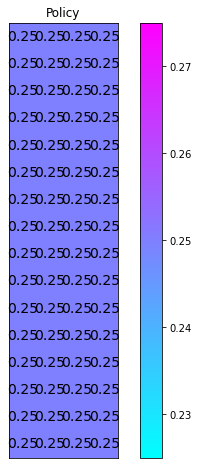

In [1159]:
#agent3.probs[:,1]=.1
#agent3.probs[2,3] =.8
plot_values(agent3.probs, size=(env_FL.nS, env_FL.nA), name = 'Policy')


### Task 1.7 Testing Frozen Lake

Similar to the case of GridWorld, **your task improve the policy of Agent3 using both Policy Iteration and Value Iteration**.
Play around with the parameters (GAMMA, MaxIter) to see if they have any effect on avoiding the death of your agent.

In [1160]:
policy_iteration(env_GW, agent3, np.ones(env_GW.nS))
run_agent(env_FL, agent3, tsleep=0.05)

  (Up)
SFFF
FHFH
FFFH
HFFG
Time step: 100
State: 2
Action: 3
Total reward: 0.0


In [1161]:
value_iteration(env_GW, agent3, np.ones(env_GW.nS))
run_agent(env_FL, agent3, tsleep=0.05)

  (Up)
SFFF
FHFH
FFFH
HFFG
Time step: 100
State: 2
Action: 3
Total reward: 0.0


Changing value of GAMA(from 0.02, 0.5, 0.2, 0.4, 0.7, 1.0) and maxIter does not affect the convergence of Frozen Lake game. It seems both method may need some correction to enable them to beat this game.